IMPORTS

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterSampler, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.stats import loguniform, randint
import seaborn as sns

# Importando os conjuntos da base de dados

In [28]:
test_path = "../test_normalized.csv"
val_path = "../val_normalized.csv"
subtrain_path = "../train_normalized.csv"

df_val = pd.read_csv(val_path, index_col=None)
df_test = pd.read_csv(test_path, index_col=None)
df_subtrain = pd.read_csv(subtrain_path, index_col=None)

In [29]:
print("Validação:", df_val.shape)
print("Teste:", df_test.shape)
print("Sub-conjunto de treinamento", df_subtrain.shape)

Validação: (7200, 23)
Teste: (9000, 23)
Sub-conjunto de treinamento (28800, 23)


In [30]:
X_train_subset = df_subtrain.drop(columns=["loan_status"])
y_train_subset  = df_subtrain["loan_status"]

X_val = df_val.drop(columns=["loan_status"])
y_val = df_val["loan_status"]

X_test = df_test.drop(columns=["loan_status"])
y_test = df_test["loan_status"]

# Unificando os conjuntos de subtreino e validação
X_train = pd.concat([X_train_subset, X_val], axis=0)
y_train= pd.concat([y_train_subset, y_val], axis=0)


# Achando os melhores hiperparâmetros

In [40]:
def build_nn(hidden_units=64, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

param_dist = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': loguniform(1e-4, 1e-2),
    'batch_size': [32, 64],
    'epochs': [50]
}

historico_acc_val = []
param_list = list(ParameterSampler(param_dist, n_iter=20, random_state=42))
todos_os_modelos = []  # Armazenará todos os modelos treinados nos folds

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for i, params in enumerate(param_list):
    print(f"\nTestando combinação {i+1}/20...")
    fold_scores = []
    modelos_desta_combinacao = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model = build_nn(
            hidden_units=params['hidden_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        model.fit(
            X_train_fold, y_train_fold,
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        modelos_desta_combinacao.append(model)  # Guarda cada modelo do fold
        
        y_val_pred = (model.predict(X_val_fold) > 0.5).astype(int).flatten()
        fold_scores.append(accuracy_score(y_val_fold, y_val_pred))
    
    # Armazena a média de F1 e todos os modelos desta combinação
    historico_acc_val.append(np.mean(fold_scores))
    todos_os_modelos.extend(modelos_desta_combinacao)  # Adiciona ao conjunto completo
    
    print(f"Acurácia média: {np.mean(fold_scores):.4f} | Parâmetros: {params}")

# Identifica a melhor combinação
indice_melhor = np.argmax(historico_acc_val)
print(f"\nMelhor acurácia média: {historico_acc_val[indice_melhor]:.4f}")
print(f"Melhores parâmetros: {param_list[indice_melhor]}")


Testando combinação 1/20...
225/225 [==============================] - 0s 693us/step
F1-Score médio: 0.9149 | Parâmetros: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_units': 128, 'learning_rate': 0.0029106359131330704}

Testando combinação 2/20...
225/225 [==============================] - 0s 2ms/step
F1-Score médio: 0.9153 | Parâmetros: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'hidden_units': 128, 'learning_rate': 0.0007792297153883001}

Testando combinação 3/20...
225/225 [==============================] - 0s 2ms/step
F1-Score médio: 0.9158 | Parâmetros: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 50, 'hidden_units': 128, 'learning_rate': 0.005399484409787433}

Testando combinação 4/20...
225/225 [==============================] - 0s 2ms/step
F1-Score médio: 0.8967 | Parâmetros: {'batch_size': 64, 'dropout_rate': 0.5, 'epochs': 50, 'hidden_units': 64, 'learning_rate': 0.00012966511753760416}

Testando combinação 5/20...
225/225 [=================

Plot e resultados da busca de hiperparâmetros

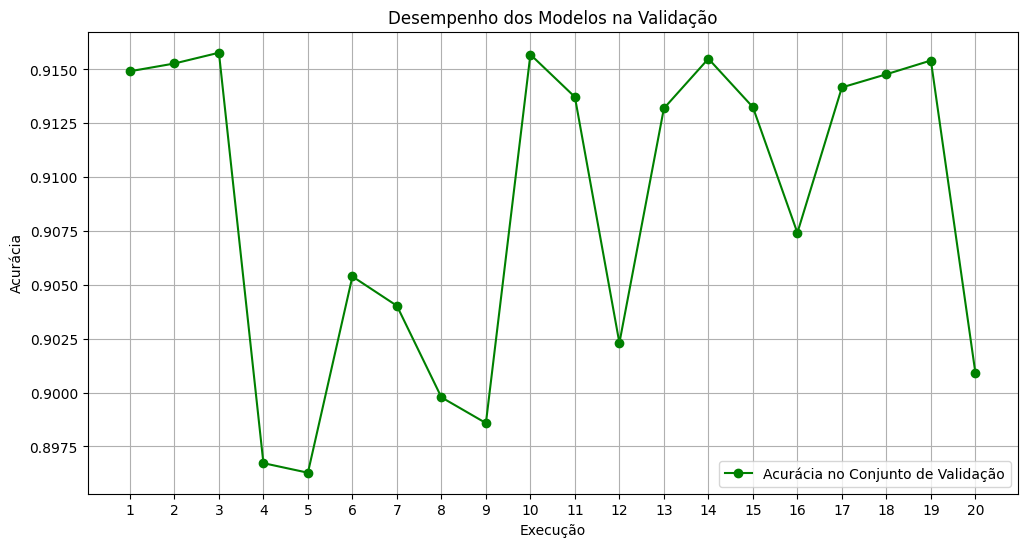

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(historico_acc_val)+1), historico_acc_val, 'g-o', label='Acurácia no Conjunto de Validação')
plt.xlabel('Execução')
plt.ylabel('Acurácia')
plt.title('Desempenho dos Modelos na Validação')
plt.xticks(range(1, len(historico_acc_val)+1))
plt.grid(True)
plt.legend()
plt.show()

# Treinando e testando o modelo

In [42]:
def ensemble_predict(models, X):
    predictions = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = (model.predict(X) > 0.5).astype(int).flatten()
    return (np.mean(predictions, axis=1) > 0.5).astype(int)

y_train_pred = ensemble_predict(melhores_modelos, X_train)
y_test_pred = ensemble_predict(melhores_modelos, X_test)

def evaluate_ensemble(models, X, y, set_name):
    y_pred = ensemble_predict(models, X)
    print(f"\nMétricas do Ensemble no {set_name}:")
    print(f"Acurácia: {accuracy_score(y, y_pred):.4f}")
    print(f"Precisão: {precision_score(y, y_pred):.4f}")
    print(f"Recall: {recall_score(y, y_pred):.4f}")
    print(f"F1-Score: {f1_score(y, y_pred):.4f}")
    return y_pred

y_train_pred = evaluate_ensemble(melhores_modelos, X_train, y_train, "Treino")
y_test_pred = evaluate_ensemble(melhores_modelos, X_test, y_test, "Teste")

1125/1125 [==============================] - 1s 674us/step

Métricas do Ensemble no Treino:
Acurácia: 0.9232
Precisão: 0.8901
Recall: 0.7464
F1-Score: 0.8119
282/282 [==============================] - 0s 610us/step

Métricas do Ensemble no Teste:
Acurácia: 0.9172
Precisão: 0.8733
Recall: 0.7340
F1-Score: 0.7976


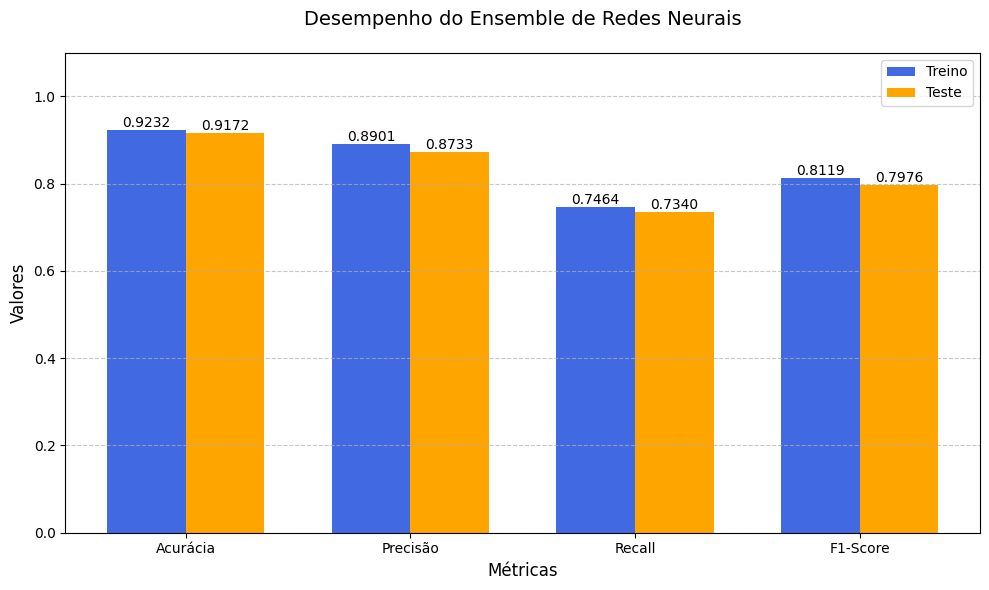

In [43]:
metricas = ["Acurácia", "Precisão", "Recall", "F1-Score"]
valores_treino = [
    accuracy_score(y_train, y_train_pred),
    precision_score(y_train, y_train_pred),
    recall_score(y_train, y_train_pred),
    f1_score(y_train, y_train_pred)
]
valores_teste = [
    accuracy_score(y_test, y_test_pred),
    precision_score(y_test, y_test_pred),
    recall_score(y_test, y_test_pred),
    f1_score(y_test, y_test_pred)
]

plt.figure(figsize=(10, 6))
x = np.arange(len(metricas))
width = 0.35

bars_train = plt.bar(x - width/2, valores_treino, width, label='Treino', color='royalblue')
bars_test = plt.bar(x + width/2, valores_teste, width, label='Teste', color='orange')

plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Valores', fontsize=12)
plt.title('Desempenho do Ensemble de Redes Neurais', fontsize=14, pad=20)
plt.xticks(x, metricas)
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bars in [bars_train, bars_test]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom', fontsize=10)

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Matriz de confusão


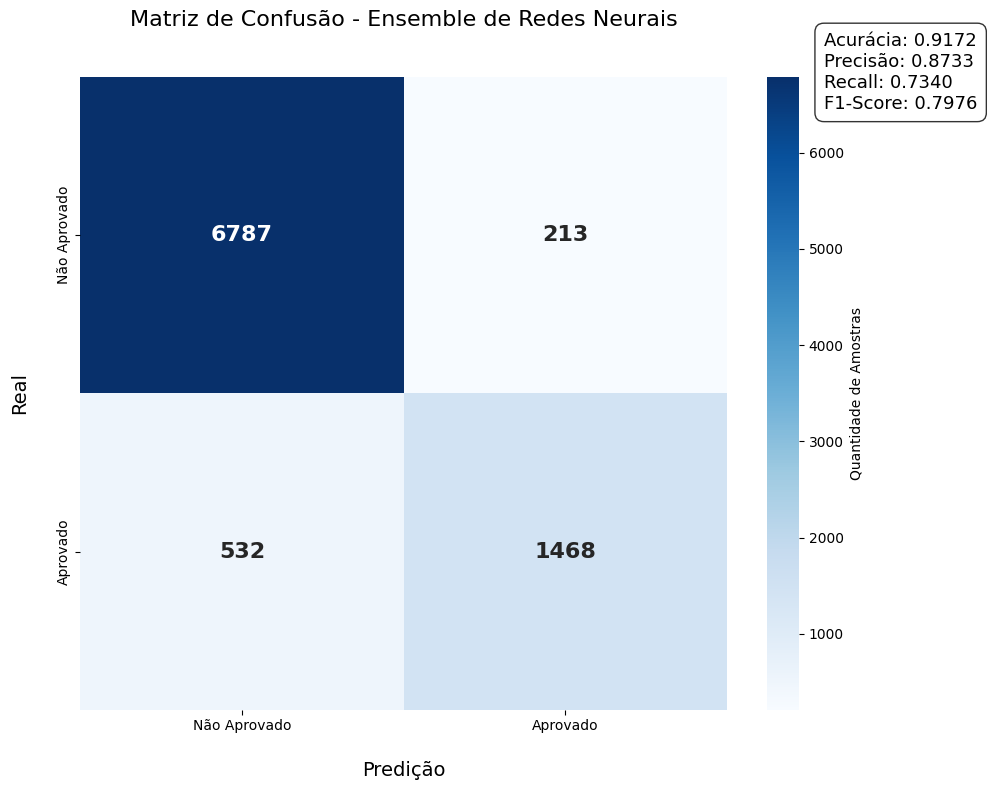

In [44]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test, y_test_pred)

ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 cbar_kws={'label': 'Quantidade de Amostras'},
                 annot_kws={"size": 16, "weight": "bold"},
                 xticklabels=['Não Aprovado', 'Aprovado'],
                 yticklabels=['Não Aprovado', 'Aprovado'])

plt.title('Matriz de Confusão - Ensemble de Redes Neurais\n', fontsize=16, pad=20)
plt.xlabel('\nPredição', fontsize=14)
plt.ylabel('Real\n', fontsize=14)

metrics_text = (f'Acurácia: {accuracy_score(y_test, y_test_pred):.4f}\n'
                f'Precisão: {precision_score(y_test, y_test_pred):.4f}\n'
                f'Recall: {recall_score(y_test, y_test_pred):.4f}\n'
                f'F1-Score: {f1_score(y_test, y_test_pred):.4f}')

plt.text(2.3, 0.1, metrics_text,
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
         fontsize=13)

plt.tight_layout()
plt.show()